This notebook is a shorter version of a great [EDA and model](https://www.kaggle.com/kulkarnivishwanath/ashrae-great-energy-predictor-iii-eda-model) notebook. It does not provide data overview, just generates the final dataframe and trains a LightGBM classifier. It can be used as a relatively quick baseline for your submission.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import random
import math
import psutil
import pickle

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder

Load the data reducing its size

In [3]:
metadata_dtype = {'site_id':"uint8",'building_id':'uint16','square_feet':'float32','year_built':'float32','floor_count':"float16"}
weather_dtype = {"site_id":"uint8",'air_temperature':"float16",'cloud_coverage':"float16",'dew_temperature':"float16",'precip_depth_1_hr':"float16",
                 'sea_level_pressure':"float32",'wind_direction':"float16",'wind_speed':"float16"}
train_dtype = {'meter':"uint8",'building_id':'uint16'}

In [4]:
%%time

weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv", parse_dates=['timestamp'], dtype=weather_dtype)
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv", parse_dates=['timestamp'], dtype=weather_dtype)

metadata = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv", dtype=metadata_dtype)

train = pd.read_csv("../input/ashrae-energy-prediction/train.csv", parse_dates=['timestamp'], dtype=train_dtype)
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv", parse_dates=['timestamp'], usecols=['building_id','meter','timestamp'], dtype=train_dtype)

print('Size of train_df data', train.shape)
print('Size of weather_train_df data', weather_train.shape)
print('Size of weather_test_df data', weather_test.shape)
print('Size of building_meta_df data', metadata.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)
CPU times: user 45.3 s, sys: 5.35 s, total: 50.6 s
Wall time: 50.4 s


Improve data readability

In [5]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

Data overview

In [6]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,Electricity,2016-01-01,0.0
1,1,Electricity,2016-01-01,0.0
2,2,Electricity,2016-01-01,0.0
3,3,Electricity,2016-01-01,0.0
4,4,Electricity,2016-01-01,0.0


In [7]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.700012,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.200012,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.200012,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.099976,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.000000,250.0,2.599609


In [8]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432.0,2008.0,NaN
1,0,1,Education,2720.0,2004.0,NaN
2,0,2,Education,5376.0,1991.0,NaN
3,0,3,Education,23685.0,2002.0,NaN
4,0,4,Education,116607.0,1975.0,NaN


In [9]:
test.head()

,building_id,meter,timestamp
0,0,Electricity,2017-01-01
1,1,Electricity,2017-01-01
2,2,Electricity,2017-01-01
3,3,Electricity,2017-01-01
4,4,Electricity,2017-01-01


Drop some columns ased on EDA

In [10]:
# Dropping floor_count variable as it has 75% missing values
metadata.drop('floor_count',axis=1,inplace=True)

Construct date features

In [11]:
for df in [train, test]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

Convert target to log scale

In [12]:
train['meter_reading'] = np.log1p(train['meter_reading'])

Preprocess metadata 


In [13]:
metadata['primary_use'].replace({"Healthcare":"Other","Parking":"Other","Warehouse/storage":"Other","Manufacturing/industrial":"Other",
                                "Retail":"Other","Services":"Other","Technology/science":"Other","Food sales and service":"Other",
                                "Utility":"Other","Religious worship":"Other"},inplace=True)
metadata['square_feet'] = np.log1p(metadata['square_feet'])
metadata['year_built'].fillna(-999, inplace=True)
metadata['year_built'] = metadata['year_built'].astype('int16')

Merge data

In [14]:
%%time
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data+Metadata Shape {}".format(train.shape))
print ("Testing Data+Metadata Shape {}".format(test.shape))
gc.collect()
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data+Metadata+Weather Shape {}".format(train.shape))
print ("Testing Data+Metadata+Weather Shape {}".format(test.shape))
gc.collect()

Training Data+Metadata Shape (20216100, 12)
Testing Data+Metadata Shape (41697600, 11)
Training Data+Metadata+Weather Shape (20216100, 19)
Testing Data+Metadata+Weather Shape (41697600, 18)
CPU times: user 33 s, sys: 30 s, total: 1min 3s
Wall time: 53.5 s


0

Prepare data

In [15]:
# Save space
for df in [train,test]:
    df['square_feet'] = df['square_feet'].astype('float16')
    
# Fill NA
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    train[col].fillna(np.nanmean(train[col].tolist()),inplace=True)
    test[col].fillna(np.nanmean(test[col].tolist()),inplace=True)
    
# Drop nonsense entries
# As per the discussion in the following thread, https://www.kaggle.com/c/ashrae-energy-prediction/discussion/117083, there is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them
idx_to_drop = list((train[(train['site_id'] == 0) & (train['timestamp'] < "2016-05-21 00:00:00")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

# dropping all the electricity meter readings that are 0, after considering them as anomalies.
idx_to_drop = list(train[(train['meter'] == "Electricity") & (train['meter_reading'] == 0)].index)
print(len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

392857
185592


In [16]:
train.head()

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
103,105,Electricity,2016-01-01,3.190624,1,1,4,0,1,Education,10.835938,-999,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
104,106,Electricity,2016-01-01,0.318163,1,1,4,0,1,Education,8.585938,-999,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
105,106,HotWater,2016-01-01,0.000000,1,1,4,0,1,Education,8.585938,-999,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
106,107,Electricity,2016-01-01,5.171529,1,1,4,0,1,Education,11.484375,2005,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
107,108,Electricity,2016-01-01,4.524668,1,1,4,0,1,Education,11.312500,1913,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609


Measure meter stats

In [17]:
%%time
number_unique_meter_per_building = train.groupby('building_id')['meter'].nunique()
train['number_unique_meter_per_building'] = train['building_id'].map(number_unique_meter_per_building)


mean_meter_reading_per_building = train.groupby('building_id')['meter_reading'].mean()
train['mean_meter_reading_per_building'] = train['building_id'].map(mean_meter_reading_per_building)
median_meter_reading_per_building = train.groupby('building_id')['meter_reading'].median()
train['median_meter_reading_per_building'] = train['building_id'].map(median_meter_reading_per_building)
std_meter_reading_per_building = train.groupby('building_id')['meter_reading'].std()
train['std_meter_reading_per_building'] = train['building_id'].map(std_meter_reading_per_building)


mean_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].mean()
train['mean_meter_reading_on_year_built'] = train['year_built'].map(mean_meter_reading_on_year_built)
median_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].median()
train['median_meter_reading_on_year_built'] = train['year_built'].map(median_meter_reading_on_year_built)
std_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].std()
train['std_meter_reading_on_year_built'] = train['year_built'].map(std_meter_reading_on_year_built)


mean_meter_reading_per_meter = train.groupby('meter')['meter_reading'].mean()
train['mean_meter_reading_per_meter'] = train['meter'].map(mean_meter_reading_per_meter)
median_meter_reading_per_meter = train.groupby('meter')['meter_reading'].median()
train['median_meter_reading_per_meter'] = train['meter'].map(median_meter_reading_per_meter)
std_meter_reading_per_meter = train.groupby('meter')['meter_reading'].std()
train['std_meter_reading_per_meter'] = train['meter'].map(std_meter_reading_per_meter)


mean_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].mean()
train['mean_meter_reading_per_primary_usage'] = train['primary_use'].map(mean_meter_reading_per_primary_usage)
median_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].median()
train['median_meter_reading_per_primary_usage'] = train['primary_use'].map(median_meter_reading_per_primary_usage)
std_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].std()
train['std_meter_reading_per_primary_usage'] = train['primary_use'].map(std_meter_reading_per_primary_usage)


mean_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].mean()
train['mean_meter_reading_per_site_id'] = train['site_id'].map(mean_meter_reading_per_site_id)
median_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].median()
train['median_meter_reading_per_site_id'] = train['site_id'].map(median_meter_reading_per_site_id)
std_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].std()
train['std_meter_reading_per_site_id'] = train['site_id'].map(std_meter_reading_per_site_id)


test['number_unique_meter_per_building'] = test['building_id'].map(number_unique_meter_per_building)

test['mean_meter_reading_per_building'] = test['building_id'].map(mean_meter_reading_per_building)
test['median_meter_reading_per_building'] = test['building_id'].map(median_meter_reading_per_building)
test['std_meter_reading_per_building'] = test['building_id'].map(std_meter_reading_per_building)

test['mean_meter_reading_on_year_built'] = test['year_built'].map(mean_meter_reading_on_year_built)
test['median_meter_reading_on_year_built'] = test['year_built'].map(median_meter_reading_on_year_built)
test['std_meter_reading_on_year_built'] = test['year_built'].map(std_meter_reading_on_year_built)

test['mean_meter_reading_per_meter'] = test['meter'].map(mean_meter_reading_per_meter)
test['median_meter_reading_per_meter'] = test['meter'].map(median_meter_reading_per_meter)
test['std_meter_reading_per_meter'] = test['meter'].map(std_meter_reading_per_meter)

test['mean_meter_reading_per_primary_usage'] = test['primary_use'].map(mean_meter_reading_per_primary_usage)
test['median_meter_reading_per_primary_usage'] = test['primary_use'].map(median_meter_reading_per_primary_usage)
test['std_meter_reading_per_primary_usage'] = test['primary_use'].map(std_meter_reading_per_primary_usage)

test['mean_meter_reading_per_site_id'] = test['site_id'].map(mean_meter_reading_per_site_id)
test['median_meter_reading_per_site_id'] = test['site_id'].map(median_meter_reading_per_site_id)
test['std_meter_reading_per_site_id'] = test['site_id'].map(std_meter_reading_per_site_id)

CPU times: user 1min 44s, sys: 47.1 s, total: 2min 31s
Wall time: 2min 11s


In [18]:
%%time
for df in [train, test]:
    df['mean_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['median_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['std_meter_reading_per_building'] = df['std_meter_reading_per_building'].astype("float16")
    
    df['mean_meter_reading_on_year_built'] = df['mean_meter_reading_on_year_built'].astype("float16")
    df['median_meter_reading_on_year_built'] = df['median_meter_reading_on_year_built'].astype("float16")
    df['std_meter_reading_on_year_built'] = df['std_meter_reading_on_year_built'].astype("float16")
    
    df['mean_meter_reading_per_meter'] = df['mean_meter_reading_per_meter'].astype("float16")
    df['median_meter_reading_per_meter'] = df['median_meter_reading_per_meter'].astype("float16")
    df['std_meter_reading_per_meter'] = df['std_meter_reading_per_meter'].astype("float16")
    
    df['mean_meter_reading_per_primary_usage'] = df['mean_meter_reading_per_primary_usage'].astype("float16")
    df['median_meter_reading_per_primary_usage'] = df['median_meter_reading_per_primary_usage'].astype("float16")
    df['std_meter_reading_per_primary_usage'] = df['std_meter_reading_per_primary_usage'].astype("float16")
    
    df['mean_meter_reading_per_site_id'] = df['mean_meter_reading_per_site_id'].astype("float16")
    df['median_meter_reading_per_site_id'] = df['median_meter_reading_per_site_id'].astype("float16")
    df['std_meter_reading_per_site_id'] = df['std_meter_reading_per_site_id'].astype("float16")
    
    df['number_unique_meter_per_building'] = df['number_unique_meter_per_building'].astype('uint8')
gc.collect()

CPU times: user 9.34 s, sys: 13.2 s, total: 22.6 s
Wall time: 14.3 s


0

Encode features

In [19]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

print (train.shape, test.shape)

(19637651, 34) (41697600, 33)


Drop correlated variables

In [20]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

There are 6 columns to remove.
Following columns can be dropped ['site_id', 'median_meter_reading_per_building', 'median_meter_reading_on_year_built', 'median_meter_reading_per_meter', 'median_meter_reading_per_primary_usage', 'median_meter_reading_per_site_id']
CPU times: user 1min 1s, sys: 13.2 s, total: 1min 14s
Wall time: 1min 8s


Split the data for train and validation with stratification by meter reading bins

In [21]:
%%time
y = train['meter_reading']
train.drop('meter_reading',axis=1,inplace=True)
categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek','DayOfMonth']

CPU times: user 784 ms, sys: 2.76 s, total: 3.54 s
Wall time: 1.96 s


In [22]:
meter_cut, bins = pd.cut(y, bins=50, retbins=True)
meter_cut.value_counts()

(-0.0169, 0.338]    1515392
(4.733, 5.071]      1465188
(4.395, 4.733]      1464363
(4.057, 4.395]      1417617
(5.071, 5.409]      1404508
(3.718, 4.057]      1269315
(3.38, 3.718]       1185807
(5.409, 5.747]      1121708
(3.042, 3.38]       1045911
(5.747, 6.085]      1039700
(6.085, 6.423]       948726
(2.704, 3.042]       819977
(6.423, 6.761]       682941
(2.366, 2.704]       588253
(6.761, 7.099]       546915
(2.028, 2.366]       452539
(7.099, 7.437]       400904
(1.69, 2.028]        397518
(1.352, 1.69]        382585
(7.437, 7.775]       288927
(1.014, 1.352]       241105
(7.775, 8.113]       216635
(0.676, 1.014]       179287
(8.113, 8.451]       154956
(0.338, 0.676]       151799
(8.451, 8.789]       103809
(8.789, 9.127]        48103
(9.127, 9.465]        33924
(9.465, 9.803]        23503
(9.803, 10.141]       12168
(10.141, 10.479]      10908
(10.479, 10.817]       9009
(10.817, 11.155]       5695
(11.155, 11.494]       2363
(11.494, 11.832]       1202
(16.564, 16.902]    

In [23]:
# x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.2,random_state=42, stratify=meter_cut)
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.1,random_state=42)
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(17673885, 27)
(17673885,)
(1963766, 27)
(1963766,)


In [24]:
x_train.head()

,building_id,meter,Month,DayOfMonth,DayOfWeek,Hour,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,number_unique_meter_per_building,mean_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,std_meter_reading_per_site_id
19302482,29,0,12,15,3,21,0,11.640625,2006,23.906250,1.900391,12.203125,0.0,1018.599976,350.0,4.101562,2,7.031250,2.060547,5.722656,1.629883,4.222656,2.523438,4.468750,2.144531,5.535156,1.632812
2233192,1158,1,2,10,2,11,5,12.593750,-999,-15.000000,1.900391,-20.000000,0.0,1021.799988,360.0,3.099609,3,5.117188,3.240234,4.277344,2.138672,4.160156,1.509766,3.998047,1.694336,4.636719,2.511719
10871563,549,1,7,18,0,7,5,9.453125,1968,26.093750,1.900391,21.703125,0.0,1020.599976,210.0,3.599609,1,3.162109,0.343506,4.574219,1.804688,4.160156,1.509766,3.998047,1.694336,3.853516,1.398438
15345430,1310,0,10,6,3,3,2,10.953125,-999,11.703125,0.000000,9.398438,0.0,1025.199951,10.0,1.500000,3,4.550781,1.432617,4.277344,2.138672,4.222656,2.523438,4.179688,1.818359,4.886719,2.251953
3013414,916,3,2,26,4,4,0,10.851562,-999,11.101562,0.000000,-1.700195,0.0,1030.099976,30.0,2.099609,3,3.169922,1.734375,4.277344,2.138672,5.125000,2.636719,4.468750,2.144531,4.585938,1.696289


Make dummies if necessary -- for RF

x_train = pd.get_dummies(x_train, columns=categorical_cols, sparse=True)

x_test = pd.get_dummies(x_test, columns=categorical_cols, sparse=True)

gc.collect()

x_train.shape

## Model

Train baseline model

In [25]:
from sklearn.ensemble import RandomForestRegressor as RF
import lightgbm as lgb

In [26]:
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_cols)
lgb_test = lgb.Dataset(x_test, y_test, categorical_feature=categorical_cols)
del x_train, x_test , y_train, y_test

params = {'feature_fraction': 0.85, # 0.75
          'bagging_fraction': 0.75,
          'objective': 'regression',
           "num_leaves": 40, # New
          'max_depth': -1,
          'learning_rate': 0.15,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'random_state': 47
         }

reg = lgb.train(params, lgb_train, num_boost_round=3000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=100)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.817297	valid_1's rmse: 0.819324
[200]	training's rmse: 0.767984	valid_1's rmse: 0.770489
[300]	training's rmse: 0.723563	valid_1's rmse: 0.726604
[400]	training's rmse: 0.698262	valid_1's rmse: 0.701656
[500]	training's rmse: 0.678516	valid_1's rmse: 0.682457
[600]	training's rmse: 0.661654	valid_1's rmse: 0.666043
[700]	training's rmse: 0.649265	valid_1's rmse: 0.654113
[800]	training's rmse: 0.638726	valid_1's rmse: 0.643982
[900]	training's rmse: 0.627946	valid_1's rmse: 0.633666
[1000]	training's rmse: 0.620176	valid_1's rmse: 0.626318
[1100]	training's rmse: 0.613177	valid_1's rmse: 0.619831
[1200]	training's rmse: 0.605427	valid_1's rmse: 0.61261
[1300]	training's rmse: 0.598115	valid_1's rmse: 0.605583
[1400]	training's rmse: 0.592225	valid_1's rmse: 0.600357
[1500]	training's rmse: 0.586365	valid_1's rmse: 0.594998
[1600]	training's rmse: 0.581425	valid_1's rmse: 0.590529
[1700]	training's rm

Check feature importance

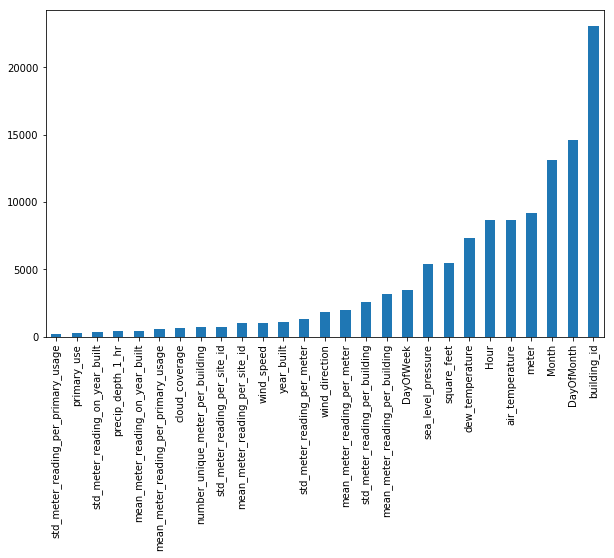

In [27]:
del lgb_train,lgb_test
ser = pd.DataFrame(reg.feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser['Importance'].plot(kind='bar',figsize=(10,6))

## Predict

In [28]:
del train

In [29]:
%%time
predictions = []
step = 50000
for i in range(0, len(test), step):
    predictions.extend(np.expm1(reg.predict(test.iloc[i: min(i+step, len(test)), :], num_iteration=reg.best_iteration)))

CPU times: user 4h 5min 34s, sys: 16 s, total: 4h 5min 50s
Wall time: 1h 3min 3s


In [30]:
%%time
Submission = pd.DataFrame(test.index,columns=['row_id'])
Submission['meter_reading'] = predictions
Submission['meter_reading'].clip(lower=0,upper=None,inplace=True)
Submission.to_csv("lgbm_fill_na.csv",index=None)

CPU times: user 4min 26s, sys: 4.2 s, total: 4min 30s
Wall time: 4min 32s
